# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 

---

## Import Packages
In this section all the python packes used in this code will be imported.

In [1]:
# Importing all packages used

import os
import math
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

## Constants Defined

All the constat values used in this project are defined in this section.

In [2]:
# Kernel size for gaussian smoothing
kernel_size          = 5

# Canny edge detectiion parameters
canny_low_threshold  = 100
canny_high_threshold = 200

# Parameters for ROI selection
roi_height           = 0.55
dist_from_side       = 0.5 # realtive to image width, max. value: 0.5 -> triangle
ignore_mask_color    = 255

# Parameters for hough line extraction
hough_rho            = 1
hough_theta          = np.pi / 360
hough_threshold      = 20
hough_min_line_len   = 80
hough_max_line_gap   = 50

# Slope threshold for line filtering and extrapolation
slope_threshold_low  = 0.5
slope_threshold_high = 0.8

## Function Definitions

In [3]:
def grayscale(img):
    """Applies the Grayscale transform.
    This will return an image with only one color channel but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray') you should call plt.imshow(gray, cmap='gray')"""
    
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """Applies an image mask.
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black. """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    # Defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    # Filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    # Returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image)"""
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """ `img` should be the output of a Canny transform.
    Returns an image with hough lines drawn"""
    
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """ `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    `initial_img` should be the image before any processing.
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape! """
    
    return cv2.addWeighted(initial_img, α, img, β, λ)

def construct_lane_lines(lines, image, slope_threshold_low = 0.5, slope_threshold_high = 0.8, verbose=False):
    """
    Filter out lines and assign lines to the left or right lane group according to their slope.
    The line equation is: y = m*x + b
    When we detect a line with a positive slope and a value greater than the pos_threshold
    it gets assigned to the left group, if the slope is negative and smaller than the negative
    threshold it gets assigned to the right group.
    
    At the end we do a linear regression line fitting for both the left and right lane lines.
    """

    if len(lines) == 0:
        print("No lines in array!")
        return []

    if verbose: 
        print("Extracting lane from %d lines" % len(lines))
    
    # Initializing arrays
    lane_lines  = []
    left_idx    = []
    right_idx   = []
    outlier_cnt = 0 
    
    min_y = image.shape[0] 
    max_y = image.shape[0]

    # Filtering lines and assigning to left or right lane group
    for i, line in enumerate(lines):
        for x1,y1,x2,y2 in line:
            dX = x2-x1
            dY = y2-y1
            slope = dY / dX
            length = np.sqrt(dX**2 + dY**2)
           
            # If positive slope, assign to right lane group
            if (slope > slope_threshold_low and slope < slope_threshold_high): 
                if verbose: print("\tFound left lane line with slope=%.2f and length=%.2f" % (slope, length)) 
                right_idx.append(i)

            # If negative slope, assign to left lane group
            elif (slope < -slope_threshold_low and slope > -slope_threshold_high): 
                if verbose: print("\tFound right lane line with slope=%.2f and length=%.2f" % (slope, length))
                left_idx.append(i)

            # An outlier
            else:
                if verbose: print("\tFound outlier line with slope=%.2f and length=%.2f" % (slope, length))
                outlier_cnt+=1

            # Update the min y (horizon)
            min_y = min(min(y1, y2), min_y)

    if verbose:
        print("Result: %d left, %d right and %d outlier detected" % (len(left_idx), len(right_idx), outlier_cnt))

    if len(right_idx) == 0 or len(left_idx) == 0:
        print("Couldn't detect both road lanes in the list of lines, %d left and %d right :(" % \
             (len(left_idx), len(right_idx)))
        return []

    # Pick out xs and ys from lines array
    left_xs  = np.array(lines[left_idx ][:, :, 0:3:2]).flatten()
    left_ys  = np.array(lines[left_idx ][:, :, 1:4:2]).flatten()
    right_xs = np.array(lines[right_idx][:, :, 0:3:2]).flatten()
    right_ys = np.array(lines[right_idx][:, :, 1:4:2]).flatten()
    
    # Linear regression for line fitting over collected points for both left and right lane
    left_slope,  left_intercept  = np.polyfit(left_xs,  left_ys, 1)
    right_slope, right_intercept = np.polyfit(right_xs, right_ys, 1)

    # Calculate pixel coordinates to describe the left and right lane line
    left_x1  = int((min_y - left_intercept)  / left_slope)
    left_x2  = int((max_y - left_intercept)  / left_slope)
    right_x1 = int((min_y - right_intercept) / right_slope)
    right_x2 = int((max_y - right_intercept) / right_slope)

    # Define the final found lines based on two points and return them
    lane_lines.append([[left_x1,  min_y, left_x2,  max_y]])
    lane_lines.append([[right_x1, min_y, right_x2, max_y]])

    return lane_lines

def process_image(image):
    # The output returns a color image (3 channel) for processing videos below
   
    ysize = image.shape[0]
    xsize = image.shape[1]
    line_img = np.zeros(image.shape, dtype=np.uint8)
    
    # Smoothing image to get better results during edge detection
    img = gaussian_blur(image, kernel_size)
    gray = canny(img, canny_low_threshold, canny_high_threshold)

    # Creating a region of interest (symmetric trapezoid) to only select interesting area in image
    vertices = np.array([[(0,                        ysize),   \
                          (xsize*dist_from_side,     ysize*roi_height), \
                          (xsize*(1-dist_from_side), ysize*roi_height), \
                          (xsize,                    ysize) \
                         ]], dtype=np.int32)
    masked_img = region_of_interest(gray, vertices)

    # Extracting straight lines from edges
    lines = cv2.HoughLinesP(masked_img, hough_rho, hough_theta, hough_threshold, np.array([]), \
                            hough_min_line_len, hough_max_line_gap)

    if annotate_all_lines:
        draw_lines(line_img, lines, color=[0, 255, 0], thickness=4)
    lines2 = construct_lane_lines(lines, image, slope_threshold_low, slope_threshold_high, verbose=False)

    draw_lines(line_img, lines2, color=[0, 100, 210], thickness=10)
    combined_img = weighted_img(line_img, image)
    return combined_img

## Read in an Image

In [4]:
# Querying for a list of images availble in the test folder
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


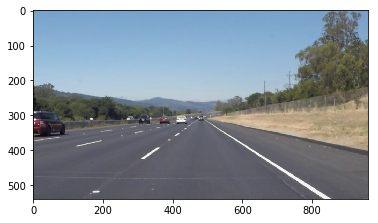

In [5]:
# Reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

# Printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Build a Lane Finding Pipeline

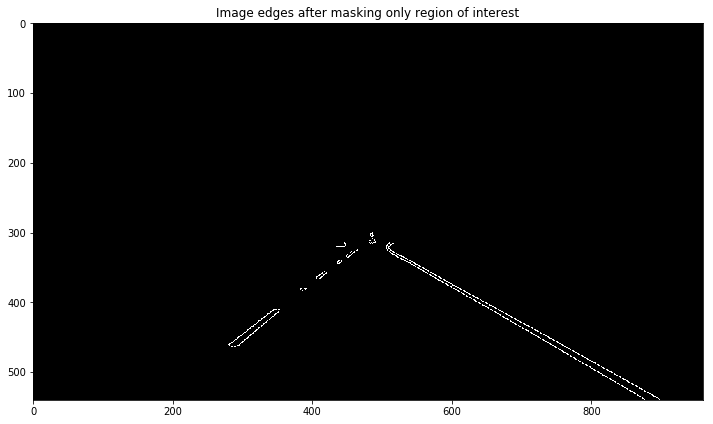

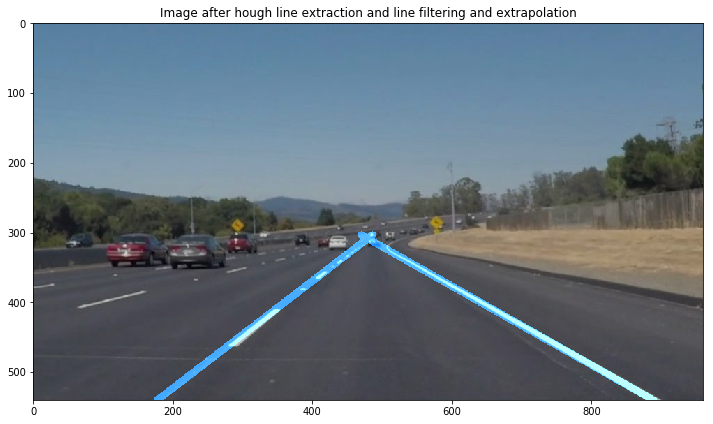

writing processes image to 'test_images_output/solidWhiteCurve.jpg'


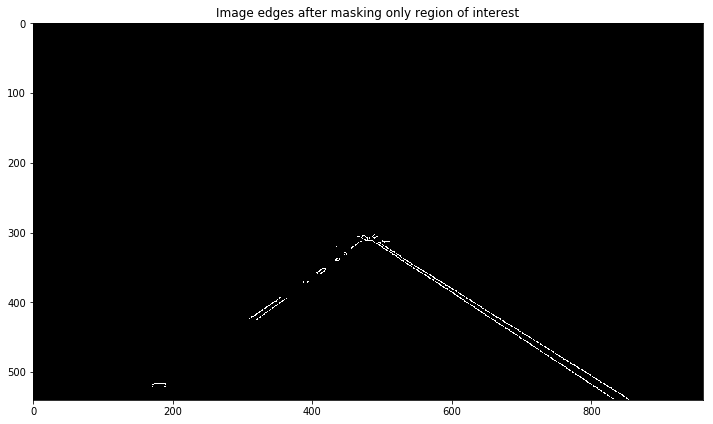

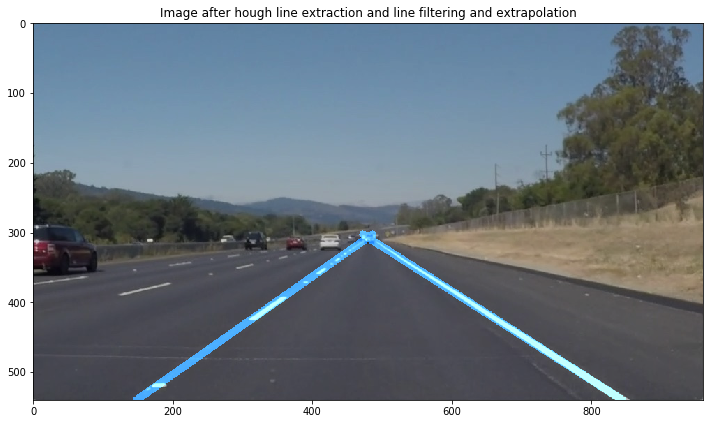

writing processes image to 'test_images_output/solidWhiteRight.jpg'


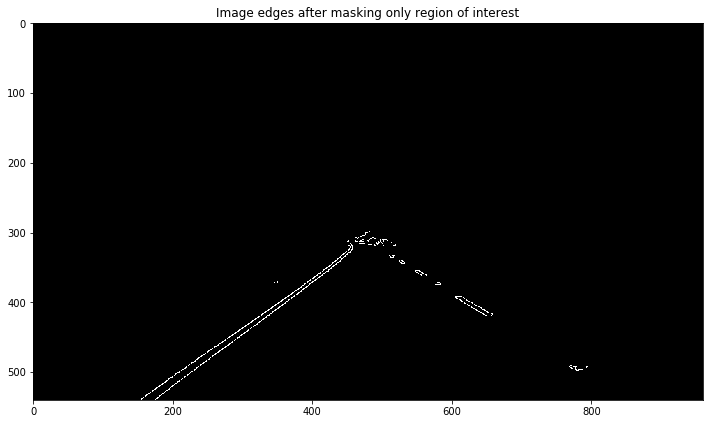

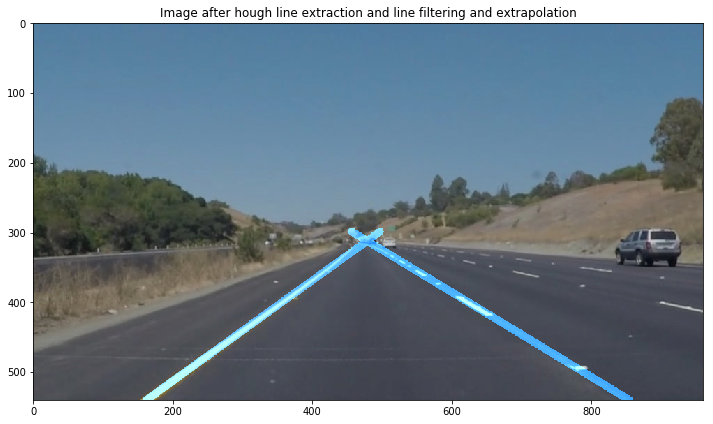

writing processes image to 'test_images_output/solidYellowCurve.jpg'


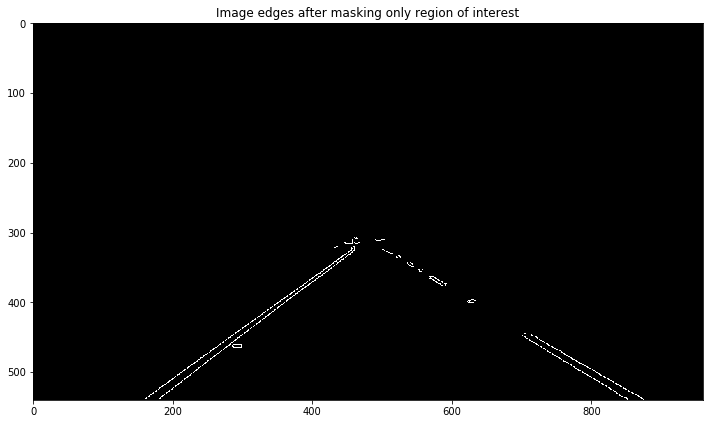

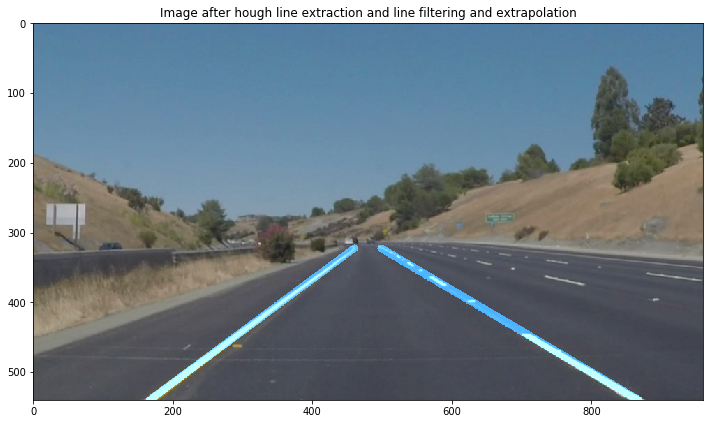

writing processes image to 'test_images_output/solidYellowCurve2.jpg'


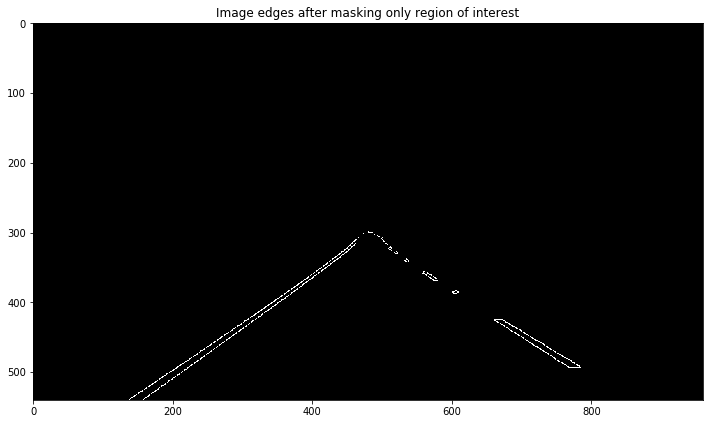

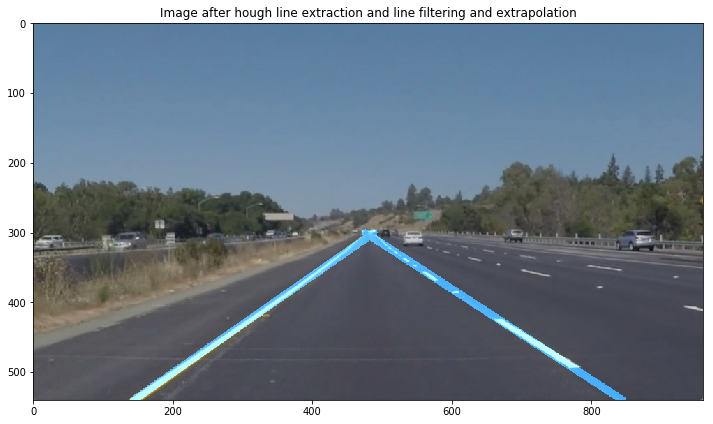

writing processes image to 'test_images_output/solidYellowLeft.jpg'


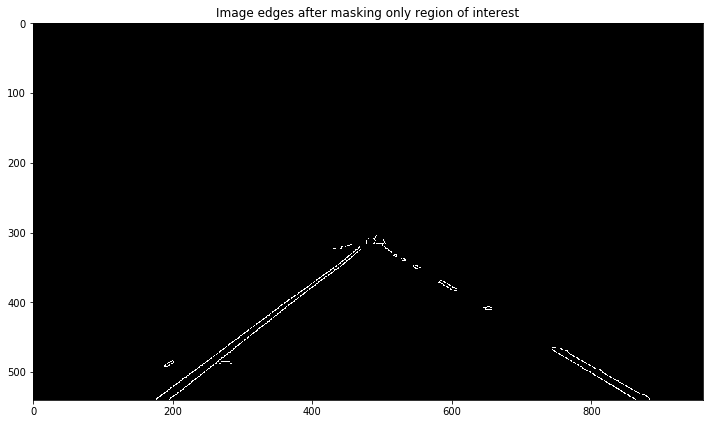

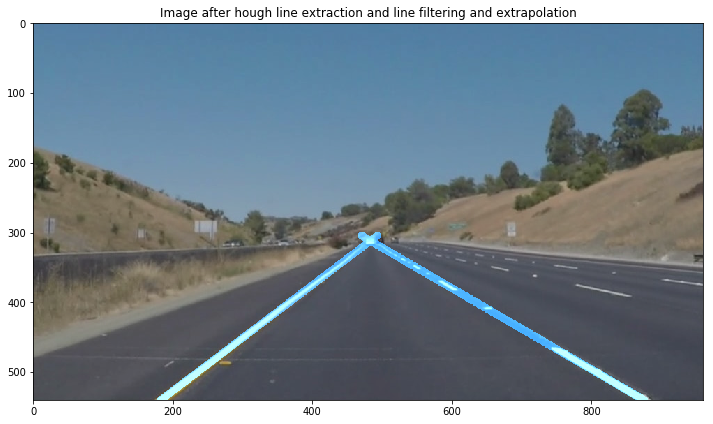

writing processes image to 'test_images_output/whiteCarLaneSwitch.jpg'


In [6]:
# Pipeline that will draw lane lines on test_images and save them to the test_images directory.

# Formatting numpy float arrays
float_formatter = lambda x: "%7.4f" % x
np.set_printoptions(formatter={'float_kind' : float_formatter})

img_src_folder = "test_images/"
img_dst_folder = "test_images_output/"
annotate_all_lines = False

# Plot size for plotting images with matplotlib in inches
plot_size = (12, 12)

# Plot images during processing
image_output = True

# Iterate over images 
imagefile_list = os.listdir("test_images/")
for imagefile in imagefile_list:
    image_path  = img_src_folder + imagefile
    image = mpimg.imread(image_path)

    ysize = image.shape[0]
    xsize = image.shape[1]

    # Smoothing image to get better results during edge detection
    img = gaussian_blur(image, kernel_size)
    gray = canny(img, canny_low_threshold, canny_high_threshold)

    # Creating a region of interest (symmetric trapezoid) to only select interesting area in image
    vertices = np.array([[(0,                        ysize),   \
                          (xsize*dist_from_side,     ysize*roi_height), \
                          (xsize*(1-dist_from_side), ysize*roi_height), \
                          (xsize,                    ysize) \
                         ]], dtype=np.int32)
    masked_img = region_of_interest(gray, vertices)
    if image_output:
        fig = plt.figure(figsize=plot_size)
        plt.title("Image edges after masking only region of interest")
        plt.imshow(masked_img, cmap='gray')
        plt.show()

    # Extracting straight lines from edges
    lines = cv2.HoughLinesP(masked_img, hough_rho, hough_theta, hough_threshold, np.array([]), \
                            hough_min_line_len, hough_max_line_gap)
    line_img = np.zeros(image.shape, dtype=np.uint8)
    
    if annotate_all_lines:
        draw_lines(line_img, lines, color=[0, 255, 0], thickness=4)
    
    lines2 = construct_lane_lines(lines, image, slope_threshold_low, slope_threshold_high, verbose=False)

    draw_lines(line_img, lines2, color=[0, 100, 210], thickness=10)
    combined_img = weighted_img(line_img, image)
    if image_output:
        fig = plt.figure(figsize=plot_size)
        plt.title("Image after hough line extraction and line filtering and extrapolation")
        plt.imshow(combined_img)
        plt.show()

    # Saving image with line overlay
    if not os.path.exists(img_dst_folder):
        os.makedirs(img_dst_folder)
    result_path = img_dst_folder + imagefile
    print("writing processes image to '%s'" % result_path)
    
    # Converting to RGB colour space first
    img_rgb = cv2.cvtColor(combined_img, cv2.COLOR_BGR2RGB)
    cv2.imwrite(result_path, img_rgb)

## Test on Videos
In this section previously identified lanes line detecting and plotting algorithm will be applied on videos; which is sequence of images stacked together.


In [7]:
# Identifying lanes lines on Solid white right lane line
video_output_folder = "test_videos_output/"
video = "solidWhiteRight.mp4"
if not os.path.exists(video_output_folder):
    os.makedirs(video_output_folder)
result_path = video_output_folder + video

clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(result_path, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:05<00:00, 39.55it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

Wall time: 5.98 s


In [8]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(result_path))

In [9]:
# Identifying lanes lines on Solid yellow left lane line
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:16<00:00, 41.86it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

Wall time: 16.7 s


In [10]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

In [11]:
# Identifying lanes lines in a curved lane line
challenge_output = 'test_videos_output/challenge.mp4'
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


 20%|█▉        | 49/251 [00:01<00:07, 25.50it/s]

Couldn't detect both road lanes in the list of lines, 8 left and 0 right :(


 37%|███▋      | 94/251 [00:03<00:07, 20.49it/s]

Couldn't detect both road lanes in the list of lines, 0 left and 4 right :(


 39%|███▊      | 97/251 [00:03<00:07, 19.97it/s]

Couldn't detect both road lanes in the list of lines, 3 left and 0 right :(


 43%|████▎     | 109/251 [00:04<00:06, 22.66it/s]

Couldn't detect both road lanes in the list of lines, 6 left and 0 right :(
Couldn't detect both road lanes in the list of lines, 8 left and 0 right :(


 58%|█████▊    | 145/251 [00:05<00:04, 24.98it/s]

Couldn't detect both road lanes in the list of lines, 12 left and 0 right :(


 59%|█████▉    | 148/251 [00:06<00:04, 24.32it/s]

Couldn't detect both road lanes in the list of lines, 8 left and 0 right :(


100%|██████████| 251/251 [00:10<00:00, 24.14it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

Wall time: 11.2 s


In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

In [ ]:
# This was a blast